# Minimal: Scan scaler *vs* motor

*APS Training for Bluesky Data Acquisition*.

**Objective**

Connect an EPICS motor PV, an EPICS scaler PV, and scan using the bluesky *RunEngine* with the *BestEffortCallback* to visualize the acquired data.

EPICS PV | Python object name | description
:--- | :--- | :---
`gp:m1` | `xpos` | motor PV (simulates a stepper motor)
`gp:scaler1` | `vsc16` | scaler PV (simulates a Joerger VSC16 scaler)

## Connect the motor

First, import the `ophyd.EpicsMotor` (class) definition.

In [1]:
from ophyd import EpicsMotor

Then, define the `xpos` object.  The EPICS PV is the first argument.  The `name="xpos"` is
required.  Make the value of this keyword argument match the name of the Python object being assigned.  The `labels=("motor",)` keyword argument enables certain features for the user interface that will be described later.

In [2]:
xpos = EpicsMotor("gp:m1", name="xpos", labels=("motor",))

Wait for that to connect with EPICS

In [3]:
xpos.wait_for_connection()

Show the position of the `xpos` motor now.

In [4]:
xpos.position

0.0

Try to move `xpos` using the IPython magic command: `%mov`.

In [5]:
# wrap in a try..except handler so notebook can run past this point
try:
    %mov xpos 1
except Exception as exc:
    print(f"Exception: {exc}")

Exception: Line magic function `%mov` not found.


Note this command fails since the IPython magic commands are not loaded automatically.  As an alternative, use the motor's `.move(SETPOINT)` method to move the motor to the new *SETPOINT* value.  Here, move `xpos` to `1`.

In [6]:
xpos.move(1)

MoveStatus(done=True, pos=xpos, elapsed=1.3, success=True, settle_time=0.0)

The `.move()` method returns a status object.  The status object may be used to report about the move or to wait for the motor to complete its move.

Next, load the IPython *Magic* commands provided by `bluesky`.  These are helpers to make the command line use easier.  Use them at your choice.

In [7]:
from bluesky.magics import BlueskyMagics
get_ipython().register_magics(BlueskyMagics)

Repeat the move of `xpos` by sending it to `0` using the magic command.

In [8]:
%mov xpos 0

xpos:   9%|██▌                         | 0.09/1.0 [00:00<00:01,  1.80s/degrees]
xpos:  19%|█████▎                      | 0.19/1.0 [00:00<00:01,  1.38s/degrees]
xpos:  29%|████████                    | 0.29/1.0 [00:00<00:00,  1.25s/degrees]
xpos:  39%|██████████▉                 | 0.39/1.0 [00:00<00:00,  1.19s/degrees]
xpos:  49%|█████████████▋              | 0.49/1.0 [00:00<00:00,  1.15s/degrees]
xpos:  59%|████████████████▌           | 0.59/1.0 [00:00<00:00,  1.12s/degrees]
xpos:  69%|███████████████████▎        | 0.69/1.0 [00:00<00:00,  1.11s/degrees]
xpos:  79%|██████████████████████      | 0.79/1.0 [00:00<00:00,  1.09s/degrees]
xpos:  89%|████████████████████████▉   | 0.89/1.0 [00:00<00:00,  1.08s/degrees]
xpos:  97%|███████████████████████████▏| 0.97/1.0 [00:01<00:00,  1.10s/degrees]
xpos: 100%|█████████████████████████████| 1.0/1.0 [00:01<00:00,  1.17s/degrees]
xpos [In progress. No progress bar available.]                                 
                                        

## Connect the scaler
As before, import the ophyd class:

In [9]:
from ophyd.scaler import ScalerCH

Then, connect with the EPICS PV.  This is similar to how the motor was connected (above).  Make the `name=` keyword match with the Python object name being created.   The `labels=("scalers", "detectors")` keyword argument enables certain features for the user interface that will be described later.

In [10]:
vsc16 = ScalerCH("gp:scaler1", name="vsc16", labels=["scalers", "detectors"])

Configure the Python object to ignore the channels with no name defined (in the `.NMnn` field of the scaler PV).

In this example control screen for our scaler, only a few of the channels are named:

![`scaler` GUI](resources/scaler.png "`scaler1` GUI")

In [11]:
vsc16.select_channels()

Show the value for each of the named channels in **our** scaler.  This will also include the most recent count time.

In [12]:
vsc16.read()

OrderedDict([('vsc16_time', {'value': 0.0, 'timestamp': 631152000.0})])

If *no* channels are shown, such as:

```python
OrderedDict([('vsc16_time', {'value': 0.0, 'timestamp': 631152000.0})])
```

then we want to name some channels here for our simulator.  We can do this directly from Python (although you would not usually want to do this at a real, operating instrument, since the channels are named as a result of hardware connections with real detectors).  We'll take channels 1-5 for `timebase`, `I0`, `scint`, `diode`, & `I00`, then skip a few channels to 11 & 12 and call them `roi1` & `roi2`, respectively.

It's OK to have empty (that is, unnamed) channels.  It's not OK to have white space in these names since the names will be used as Python objects within bluesky.  That also means no other characters (such as math symbols and such) that cannot be used as a [Python object name](https://www.python.org/dev/peps/pep-0008/#naming-conventions).  Also, do not use the same name in two different scaler channels.

In [13]:
vsc16.channels.chan01.chname.put("timebase")
vsc16.channels.chan02.chname.put("I0")
vsc16.channels.chan03.chname.put("scint")
vsc16.channels.chan04.chname.put("diode")
vsc16.channels.chan05.chname.put("I00")
vsc16.channels.chan11.chname.put("roi1")
vsc16.channels.chan12.chname.put("roi2")

Then select the named channels and read again:

In [14]:
vsc16.select_channels()
vsc16.read()

OrderedDict([('timebase', {'value': 0.0, 'timestamp': 631152000.0}),
             ('roi1', {'value': 0.0, 'timestamp': 631152000.0}),
             ('roi2', {'value': 0.0, 'timestamp': 631152000.0}),
             ('vsc16_time', {'value': 0.0, 'timestamp': 631152000.0})])

### Set the scaler's counting time

The `ScalerCH` class defines the count time as the `preset_time` attribute.  Show it's value:

In [15]:
vsc16.preset_time.get()

1.0

Set the counting time to 0.5 s using the `%mov` magic command (same command that moves a motor).

In [16]:
%mov vsc16.preset_time 0.5

Use the IPython `%ct` magic command to count each object with the `detectors` label keyword.

In [17]:
%ct

[This data will not be saved. Use the RunEngine to collect data.]
timebase                       6000000.0
roi1                           0.0
roi2                           0.0
vsc16_time                     0.6


### `labels` and the `%wa` magic command

As noted above, the `labels=LIST` keyword argument used when the motor and scaler objects were create enable certain features.  For example, the `%ct` magic command will count all the `detectors`.

Actually, `detectors` is the default argument for the `%ct` magic.  If an arument is supplied, it is the name of a label to be matched.  This is why the additional label of `scalers` was included.  Thus, we could count *only* `scalers` with the command `%ct scalers`.

Use the `labels` keyword liberally to group similar objects.

The `%wa` magic shows relevant information for all labeled objects (or, for the named label if supplied).  For example:

In [18]:
%wa

motor
  Positioner                     Value       Low Limit   High Limit  Offset     
  xpos                           0.0         -32000.0    32000.0     0.0        

  Local variable name                    Ophyd name (to be recorded as metadata)
  xpos                                   xpos                                  

detectors
  Local variable name                    Ophyd name (to be recorded as metadata)
  vsc16                                  vsc16                                 

scalers
  Local variable name                    Ophyd name (to be recorded as metadata)
  vsc16                                  vsc16                                 



In [19]:
%wa motor

motor
  Positioner                     Value       Low Limit   High Limit  Offset     
  xpos                           0.0         -32000.0    32000.0     0.0        

  Local variable name                    Ophyd name (to be recorded as metadata)
  xpos                                   xpos                                  



## Prepare to scan

Before we can run our first bluesky scan, we have to import various software tools.

First is the bluesky `RunEngine()`, which will manage the various activities for the scan (move motor, wait, trigger scaler, wait, collect channel data, publish to data subscribers, ...).

Create a `RunEngine()` object.  The argument here is a dictionary (empty in this training session).  (For routine operations at an instrument, the dictionary is filled with information saved from the previous session.)

In [20]:
import bluesky
RE = bluesky.RunEngine({})

To save the acquired data, we connect with a MongoDB database using a preconfigured datafile that describes our *training* catalog.  Using the IPython `!` technique to issue a Linux command from an IPython session, we `cat` (concatenate) the contents of that file to the output here:

In [21]:
!cat ~/.local/share/intake/training.yml

# file: training.yml
# purpose: Configuration file to connect Bluesky databroker with MongoDB
# For Bluesky Python Training at APS

# Copy to: ~/.local/share/intake/training.yml
# Create subdirectories as needed

sources:
  training:
    args:
      asset_registry_db: mongodb://localhost:27017/training-bluesky
      metadatastore_db: mongodb://localhost:27017/training-bluesky
    driver: bluesky-mongo-normalized-catalog



To connect, we need the *training* catalog.  This name is provided by the line indented after the `sources:` line in the above `.yml` file.  (The name of the `.yml` file does not matter.  The `databroker.catalog` software will look through all `.yml` files in this directory for the`training` configuration.)

We'll use the reference to our databroker catalog frequently, so we give it a short name.

In [22]:
import databroker
db = databroker.catalog["training"]

/home/mintadmin/Apps/anaconda/envs/bluesky_2021_1/lib/python3.8/site-packages/databroker/core.py:1856: UserWarning: There are 2 entrypoints for the databroker handler spec 'NPY_SEQ'. They are [EntryPoint('NPY_SEQ', 'ophyd.sim', 'NumpySeqHandler', Distribution('ophyd', '1.6.0')), EntryPoint('NPY_SEQ', 'ophyd.sim', 'NumpySeqHandler', None)]. The match EntryPoint('NPY_SEQ', 'ophyd.sim', 'NumpySeqHandler', Distribution('ophyd', '1.6.0')) has won the race.
  warnings.warn(


How many (bluesky data collection) *runs* are recorded in this catalog?  Get its *length*:

In [23]:
len(db)

32

Configure `RE` to publish the run data to our `db` object.  We must use the `.v1` software interface for legacy reasons.

In [24]:
RE.subscribe(db.v1.insert)

0

A progress bar can be helpful to show that long operations are actually progressing.  These steps load a progress bar and configure `RE`.

In [25]:
from bluesky.utils import ProgressBarManager
pbar_manager = ProgressBarManager()
RE.waiting_hook = pbar_manager

The `BestEffortCallback` provides easy visualization of data (tables, plots, peaks statistics) as it is acquired by the `RE`.  Subscribe it to the `RE` so it receives data during a `RE()` run.

In [26]:
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()
RE.subscribe(bec)
peaks = bec.peaks

Supplemental *baseline* data is recorded before and after each run.  Additionally, EPICS Channel Access monitors can update PVs asynchronous to the primary data acquisition.  These *monitor*s can be saved as additional data streams in a run.  Prepare to use this feature.

In [27]:
from bluesky import SupplementalData
sd = SupplementalData()
RE.preprocessors.append(sd)

Add the name of this notebook as metadata to every run.  This is done by adding to the RunEngine's metadata dictionary (`RE.md`), content that will be added to the *start* document of every run.  The metadata is useful documentation about a run and can be used for several purposes, such as to record a general condition (such as the name of this notebook) or to identify these runs from a database search.

In [28]:
RE.md["notebook"] = "basic-motor-scaler-scan"

## First scan

The standard plans provided in `bluesky.plans` are sufficient for many needs, so import them and, in the same command, give the package a short name (`bp`) since it is used frequently.

In [29]:
from bluesky import plans as bp

The [`scan()`](https://blueskyproject.io/bluesky/generated/bluesky.plans.scan.html#bluesky.plans.scan) plan is flexible and will be used here to scan scaler *vs.* motor.  The first argument is the *list* of detectors to be recorded.  Here, we give the scaler object `vsc16`.  The next argument is the positioner object, then start and end positions, finally, the number of points to be collected.

Observe that we do not run the scan directly, but rather give the scan to the `RE()` object.  The `RE()` object will run the scan, performing each of the actions defined by the scan, but also handle the additional tasks of managing the data acquisition process, publishing data to all subscribers (here: databroker and BestEffortCallback) and checking for updates from EPICS and checking if the run must be interrupted either by user request or some other observation.  (We have not configured any of those other observations in this simple example.)



Transient Scan ID: 1     Time: 2021-05-14 16:37:07
Persistent Unique Scan ID: '4127b5e8-5269-4b86-a4ea-c63a84190a69'
xpos:   9%|██▌                         | 0.09/1.0 [00:00<00:01,  1.73s/degrees]
xpos:  19%|█████▎                      | 0.19/1.0 [00:00<00:01,  1.35s/degrees]
xpos:  29%|████████                    | 0.29/1.0 [00:00<00:00,  1.23s/degrees]
xpos:  39%|██████████▉                 | 0.39/1.0 [00:00<00:00,  1.17s/degrees]
xpos:  49%|█████████████▋              | 0.49/1.0 [00:00<00:00,  1.14s/degrees]
xpos:  59%|████████████████▌           | 0.59/1.0 [00:00<00:00,  1.12s/degrees]
xpos:  69%|███████████████████▎        | 0.69/1.0 [00:00<00:00,  1.10s/degrees]
xpos:  79%|██████████████████████      | 0.79/1.0 [00:00<00:00,  1.09s/degrees]
xpos:  89%|████████████████████████▉   | 0.89/1.0 [00:00<00:00,  1.08s/degrees]
xpos:  97%|███████████████████████████▏| 0.97/1.0 [00:01<00:00,  1.10s/degrees]
xpos: 100%|█████████████████████████████| 1.0/1.0 [00:01<00:00,  1.16s/degrees]
x

/home/mintadmin/Apps/anaconda/envs/bluesky_2021_1/lib/python3.8/site-packages/bluesky/callbacks/fitting.py:165: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(input * grids[dir].astype(float), labels, index) / normalizer


('4127b5e8-5269-4b86-a4ea-c63a84190a69',)

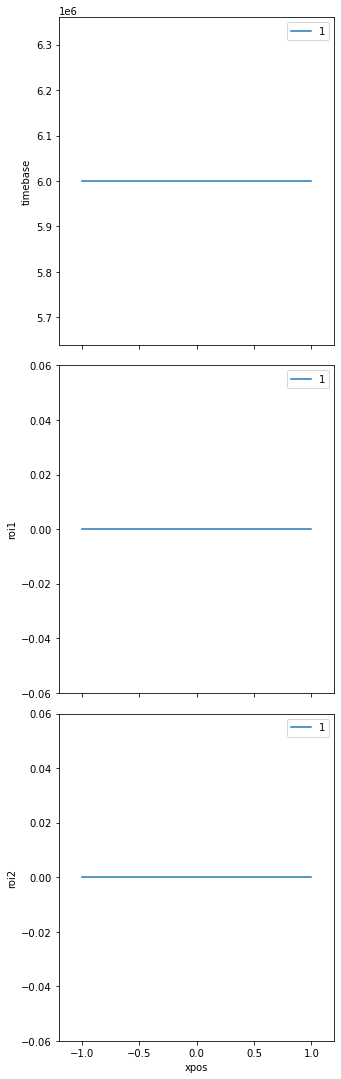

In [30]:
RE(bp.scan([vsc16], xpos, -1, 1, 7))

The scan ran, data was collected and printed at each step of the scan.  Finally, plots were made of the scaler channel *vs* motor position for each active channel.

There were some problems.  First is that an error was reported after the scan (`... callbacks/fitting.py:165: RuntimeWarning: invalid value encountered in double_scalars `).  This error is because the scalers showed no peak during the scan.  The scaler is a simulator with no real data.  We'll ignore that error here.

Another problem is that the scaler counts for 0.1s longer than we have configured.  This is a problem with the underlying EPICS support for a simulated (a.k.a. *soft channel*) scaler.  We'll ignore that error here.

Next problem is that the progress bar is a nuisance in this notebook so we'll remove it.

In [31]:
RE.waiting_hook = None

Then, repeat the same scan.



Transient Scan ID: 2     Time: 2021-05-14 16:37:19
Persistent Unique Scan ID: '7068e871-c812-4dc1-a5d5-fa64d7bff9f0'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time |       xpos |   timebase |       roi1 |       roi2 |
+-----------+------------+------------+------------+------------+------------+
|         1 | 16:37:22.3 |   -1.00000 |    6000000 |          0 |          0 |
|         2 | 16:37:23.7 |   -0.67000 |    6000000 |          0 |          0 |
|         3 | 16:37:25.2 |   -0.33000 |    6000000 |          0 |          0 |
|         4 | 16:37:26.6 |    0.00000 |    6000000 |          0 |          0 |
|         5 | 16:37:28.1 |    0.33000 |    6000000 |          0 |          0 |
|         6 | 16:37:29.5 |    0.67000 |    6000000 |          0 |          0 |
|         7 | 16:37:31.0 |    1.00000 |    6000000 |          0 |          0 |
+-----------+------------+------------+------------+------------+----

('7068e871-c812-4dc1-a5d5-fa64d7bff9f0',)

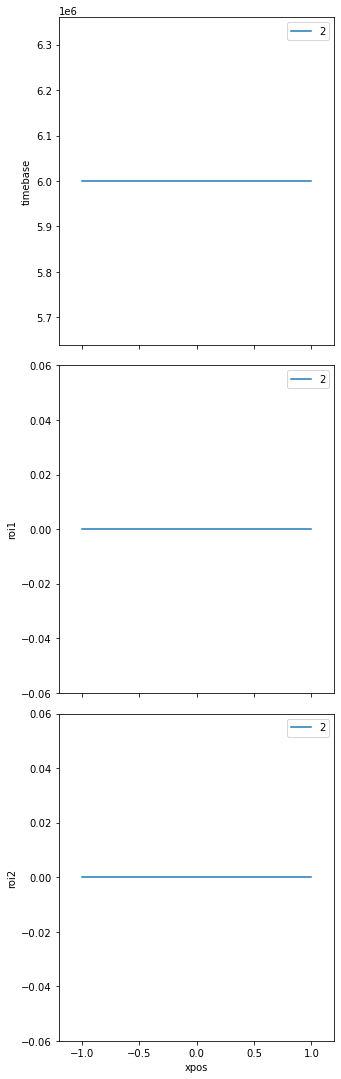

In [32]:
RE(bp.scan([vsc16], xpos, -1, 1, 7))

## Scan with a *different* counting time : staging

Suppose that we wish to use a different counting time, we could change the `vsc16.preset_time` value before running the scan.  Another way is to use the `ophyd` concept of [*stage* & *unstage*](https://blueskyproject.io/ophyd/device-overview.html?highlight=staging#stage-and-unstage).  

*Staging* is the action of preparing an ophyd device for operation, then resetting it afterwards to its previous values.  For our scaler, we could *stage* a different counting time that would be used during the run, then removed after the run is complete.  The `stage()` and `unstage()` methods are controlled by an `OrderedDictionary` where the keys are the attributes of the Python object and the values are used during the run.  The `RE()` takes care of calling `stage()` and `unstage()` during the scan.

Here we show staging of a 2.0s `preset_time` for the run.  Also shown are the `preset_time` value before and after the run.

In [33]:
print(f"{vsc16.preset_time.get() = }")

vsc16.preset_time.get() = 0.5


In [34]:
vsc16.stage_sigs["preset_time"] = 2.0

Repeat the same scan.



Transient Scan ID: 3     Time: 2021-05-14 16:37:31
Persistent Unique Scan ID: '06fab42c-aed9-4645-95b1-533043c37fd8'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time |       xpos |   timebase |       roi1 |       roi2 |
+-----------+------------+------------+------------+------------+------------+
|         1 | 16:37:36.5 |   -1.00000 |   21000000 |          0 |          0 |
|         2 | 16:37:39.5 |   -0.67000 |   21000000 |          0 |          0 |
|         3 | 16:37:42.4 |   -0.33000 |   21000000 |          0 |          0 |
|         4 | 16:37:45.3 |    0.00000 |   21000000 |          0 |          0 |
|         5 | 16:37:48.2 |    0.33000 |   21000000 |          0 |          0 |
|         6 | 16:37:51.1 |    0.67000 |   21000000 |          0 |          0 |
|         7 | 16:37:54.1 |    1.00000 |   21000000 |          0 |          0 |
+-----------+------------+------------+------------+------------+----

('06fab42c-aed9-4645-95b1-533043c37fd8',)

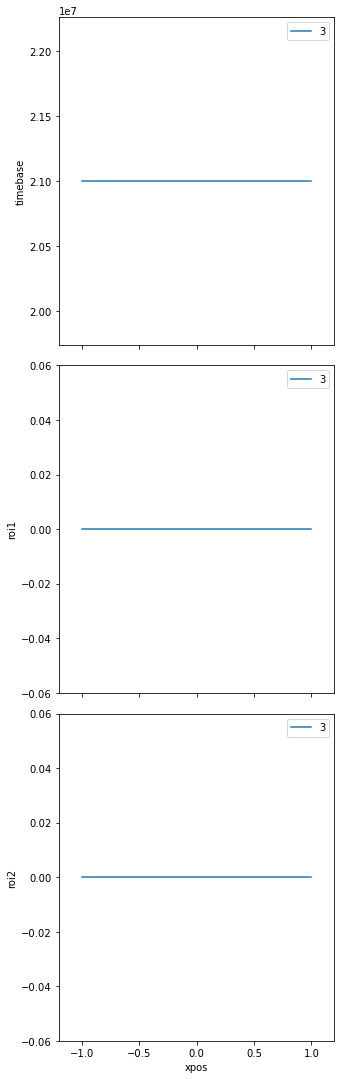

In [35]:
RE(bp.scan([vsc16], xpos, -1, 1, 7))

In [36]:
print(f"{vsc16.preset_time.get() = }")

vsc16.preset_time.get() = 0.5


## Custom plan with configurable count time

It is common to want to set the count time at the time the scan is started.  For this feature, a custom scan plan is needed, where we will repeat the steps just shown.  This plan will use similar arguments as the `bp.scan()` used above, but add an optional keyword argument `ct` for the count time with a default of 1.0 second.  For housekeeping, we'll remove the staging configuration from the scaler after the scan.

A bluesky *plan* is a Python generator.  The `bp.scan()` call is the part that makes this a generator, deferring execution of the actual scan until the `RE()` calls for it.

In [37]:
def tscan(scaler, pos, pStart, pEnd, nPts, ct=1):
    scaler.stage_sigs["preset_time"] = ct
    print(f"{scaler.preset_time.get() = }")

    yield from bp.scan([scaler], pos, pStart, pEnd, nPts)

    print(f"{scaler.preset_time.get() = }")
    del scaler.stage_sigs["preset_time"]

Run the custom plan.

scaler.preset_time.get() = 0.5


Transient Scan ID: 4     Time: 2021-05-14 16:37:54
Persistent Unique Scan ID: '25883bc1-0234-4c2b-8bc7-9263e73a093a'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time |       xpos |   timebase |       roi1 |       roi2 |
+-----------+------------+------------+------------+------------+------------+
|         1 | 16:37:57.5 |   -1.00000 |    2000000 |          0 |          0 |
|         2 | 16:37:58.5 |   -0.67000 |    1000000 |          0 |          0 |
|         3 | 16:37:59.6 |   -0.33000 |    1000000 |          0 |          0 |
|         4 | 16:38:00.6 |    0.00000 |    2000000 |          0 |          0 |
|         5 | 16:38:01.6 |    0.33000 |    2000000 |          0 |          0 |
|         6 | 16:38:02.7 |    0.67000 |    2000000 |          0 |          0 |
|         7 | 16:38:03.7 |    1.00000 |    2000000 |          0 |          0 |
+-----------+------------+------------

('25883bc1-0234-4c2b-8bc7-9263e73a093a',)

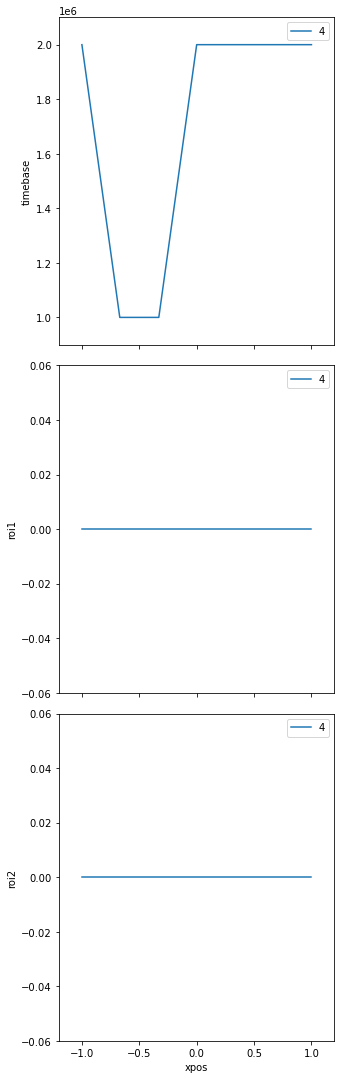

In [38]:
RE(tscan(vsc16, xpos, -1, 1, 7, 0.1))

## Challenges

Try these additional modifications or activities.

1. Use `logger` to report at various places.

   _Hint_: `logger.info("text: %s  value: %g", s1, v2, ...)`

   Consider examples as used in [`peak_finder_example.py`](instrument/plans/peak_finder_example.py).
   See the [Python logging tutorial](https://docs.python.org/3/howto/logging.html) for more information.
1. Write a custom plan that accepts user-provided metadata.

   _Hint_: [`bp.scan()`](https://blueskyproject.io/bluesky/generated/bluesky.plans.scan.html#bluesky.plans.scan) has the `md` keyword argument (_kwarg_) that accepts a dictionary of _key: value_ pairs as the metadata when the plan is run.  Your custom plan should accept the same kwarg and pass this to `bp.scan(md=the_dictionary)`, possibly after adding some of its own keys to the metadata.